In [15]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [55]:
from fastai import *
from fastai.vision import *

np.random.seed(43)
#defaults.device = torch.device('cuda')

%cd ./
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=30, max_lighting=0.2)
data = (ImageList
    .from_folder(Path('./data'))
    .split_by_rand_pct()
    .label_from_folder()
    .transform(tfms, size=224)
    .databunch(bs=32)
    .normalize(imagenet_stats)
)

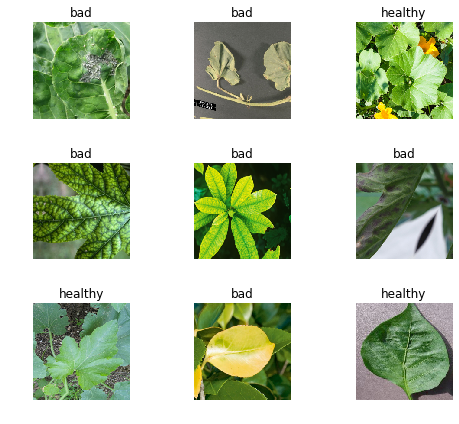

In [26]:
data.show_batch(rows=3, figsize=(7,6))

In [88]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
# learn.fit_one_cycle(1, max_lr=slice(lr))

In [56]:
learn.load('stage-2-resnet34')
learn.data = data
learn.validate()  # loss, metrics

[0.00088038447, tensor(0.)]

In [ ]:
# find optimal LR - useful for new configurations
# learn.lr_find(start_lr=1e-8, end_lr=1e3)
# learn.recorder.plot()

In [ ]:
# write LR from previous step into here
lr = 1e-2
learn.freeze()
learn.fit_one_cycle(1, max_lr=slice(lr), moms=(0.8, 0.7))
learn.save('stage-1-resnet34')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(50, max_lr=slice(1e-6, lr), moms=(0.8, 0.7))
learn.recorder.plot()

In [ ]:
learn.save('stage-2-resnet34')
learn.export()

In [57]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

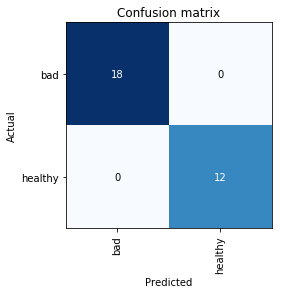

In [58]:
interp.plot_confusion_matrix()

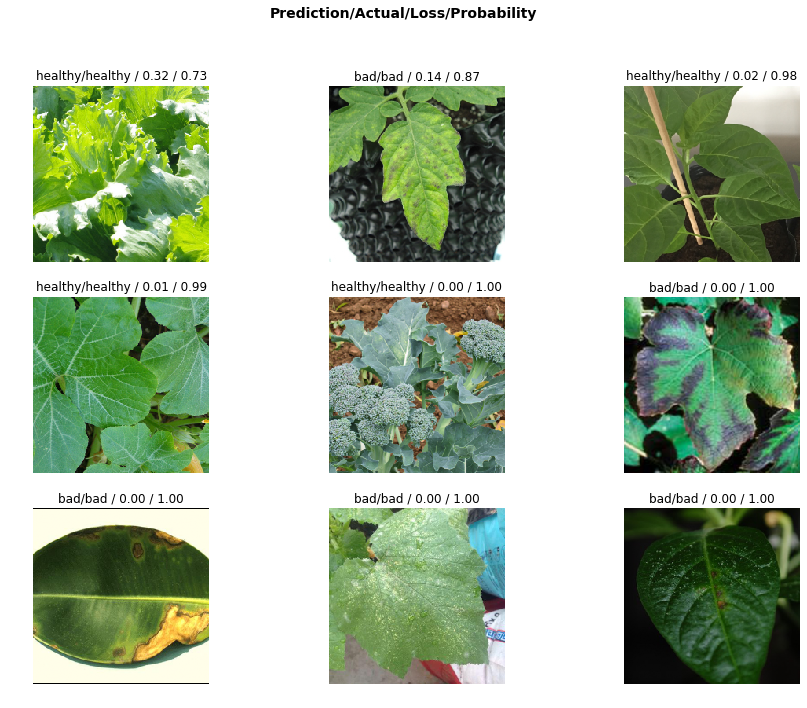

In [31]:
interp.plot_top_losses(9, figsize=(15,11))

[('bad', 0.8529999852180481), ('healthy', 0.1469999998807907)]

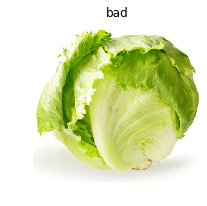

In [89]:
img = open_image("/Users/temoto/Downloads/plantnet-salat.jpg")
klass, _, probs = learn.predict(img)
img.show(y=klass)
sorted([(c, ((t*1000).round()/1000).item()) for c, t in zip(data.classes, probs)], key=lambda t: t[1], reverse=True)